In [39]:
# import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
import folium
from geopy.geocoders import Nominatim
from datetime import datetime

In [40]:
!unzip EVChargingStationUsage.zip

Archive:  EVChargingStationUsage.zip
replace EVChargingStationUsage.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: EVChargingStationUsage.csv  


In [41]:

# make dataframe from csv file EVChargingStationUsage.csv and set low_memory to false
df = pd.read_csv('EVChargingStationUsage.csv')


<ipython-input-41-a1a184cd5ac8>:2: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('EVChargingStationUsage.csv')


In [42]:
# print column names
df.columns

Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code',
       'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By',
       'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County',
       'System S/N', 'Model Number'],
      dtype='object')

# Preprocessing

In [43]:
# remove spaces from station names
df['Station Name'] = df['Station Name'].str.replace(' ', '')

In [44]:
def convert_to_utc(row):
    try:
        # Try parsing with '/' format first
        dt = datetime.strptime(row['Start Date'], "%m/%d/%Y %H:%M")
    except ValueError:
        # If parsing with '/' format fails, use '-' format
        dt = datetime.strptime(row['Start Date'], "%m-%d-%Y %H:%M")

    tz = (
        pytz.timezone('America/Los_Angeles')
        if row['Start Time Zone'] in ('PDT', 'PST')
        else pytz.timezone('UTC')
    )

    return tz.localize(dt).astimezone(pytz.utc)

# Apply the conversion function and create a new column 'datetime_utc'
df['Start Date'] = df.apply(convert_to_utc, axis=1)

# Drop the 'Start Time Zone' column
df.drop(columns=['Start Time Zone'], inplace=True)

print(df['Start Date'].head())

0   2011-07-30 03:17:00+00:00
1   2011-07-30 07:00:00+00:00
2   2011-07-30 15:16:00+00:00
3   2011-07-30 21:51:00+00:00
4   2011-07-31 01:51:00+00:00
Name: Start Date, dtype: datetime64[ns, UTC]


In [45]:
df['Start Month'] = df['Start Date'].dt.month
df['Day of Week'] = df['Start Date'].dt.day_name()
df['Start Year'] = df['Start Date'].dt.year
df['Minutes Passed From The Day'] = df['Start Date'].dt.hour * 60 + df['Start Date'].dt.minute

# Create a new column waiting time which is difference between total duration and charging time in minutes
df['Waiting Time'] = df['Total Duration (hh:mm:ss)'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1])) - df['Charging Time (hh:mm:ss)'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

# Create a new column charging time in minutes
df['Charging Time'] = df['Charging Time (hh:mm:ss)'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

In [46]:
df['Station Name'] = df['Station Name'].astype('category').cat.codes
df['Day of Week'] = df['Day of Week'].astype('category').cat.codes

In [47]:
df.drop(columns=['Org Name', 'End Date', 'End Time Zone', 'Charging Time (hh:mm:ss)', 'Transaction Date (Pacific Time)', 'Address 1', 'City', 'State/Province', 'Country', 'Ended By', 'Plug In Event Id', 'County', 'System S/N', 'Model Number'], inplace=True)

In [48]:
# print column names
df.columns

Index(['Station Name', 'MAC Address', 'Start Date',
       'Total Duration (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Postal Code', 'Latitude', 'Longitude', 'Currency', 'Fee',
       'Driver Postal Code', 'User ID', 'Start Month', 'Day of Week',
       'Start Year', 'Minutes Passed From The Day', 'Waiting Time',
       'Charging Time'],
      dtype='object')

# Visualize the data

In [49]:
# create a new dataframe with Station Name, latitude, longitude, Postal Code
df_map = df[['Latitude', 'Longitude', 'Station Name']]

# group by Station Name and update df_map
df_map = df_map.groupby('Station Name').first()

# Create a map centered at California's coordinates
m = folium.Map(location=[36.7783, -119.4179], zoom_start=7)

# Iterate through the filtered DataFrame rows and add markers for each station
for index, row in df_map.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']]
    ).add_to(m)

# Display the map
m

#### Visualizing the relationship between Energy and GHG Savings, Gasoline Savings

Text(0.5, 1.0, 'Energy vs Gasoline Savings')

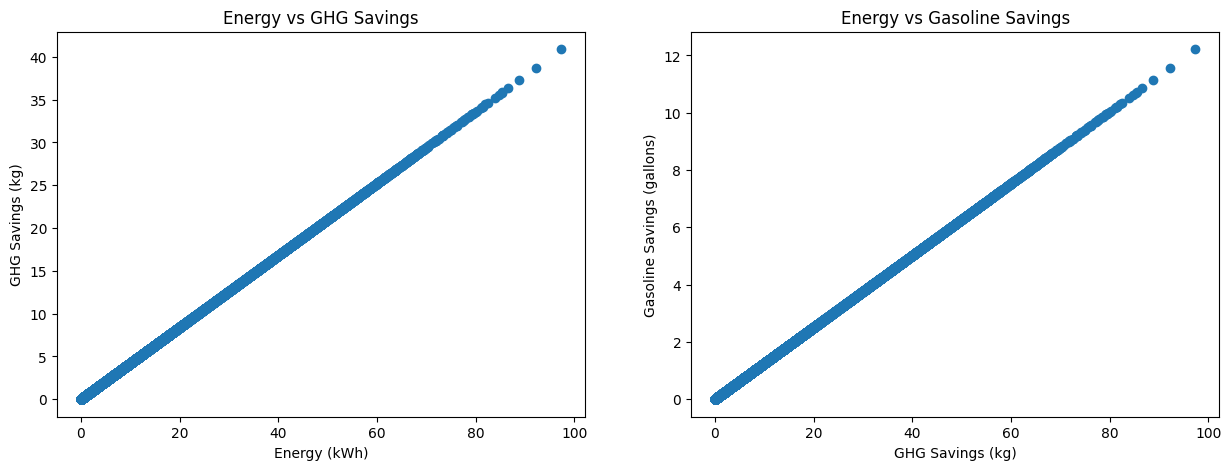

In [50]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create box plots for each dataset
axes[0].scatter(df['Energy (kWh)'], df['GHG Savings (kg)'])
axes[0].set_xlabel('Energy (kWh)')
axes[0].set_ylabel('GHG Savings (kg)')
axes[0].set_title('Energy vs GHG Savings')

axes[1].scatter(df['Energy (kWh)'], df['Gasoline Savings (gallons)'])
axes[1].set_xlabel('GHG Savings (kg)')
axes[1].set_ylabel('Gasoline Savings (gallons)')
axes[1].set_title('Energy vs Gasoline Savings')

#### Visualizing the relationship between Charging Time and Energy, GHG Savings, Gasoline Savings

Text(0.5, 1.0, 'Charging Time vs GHG Savings')

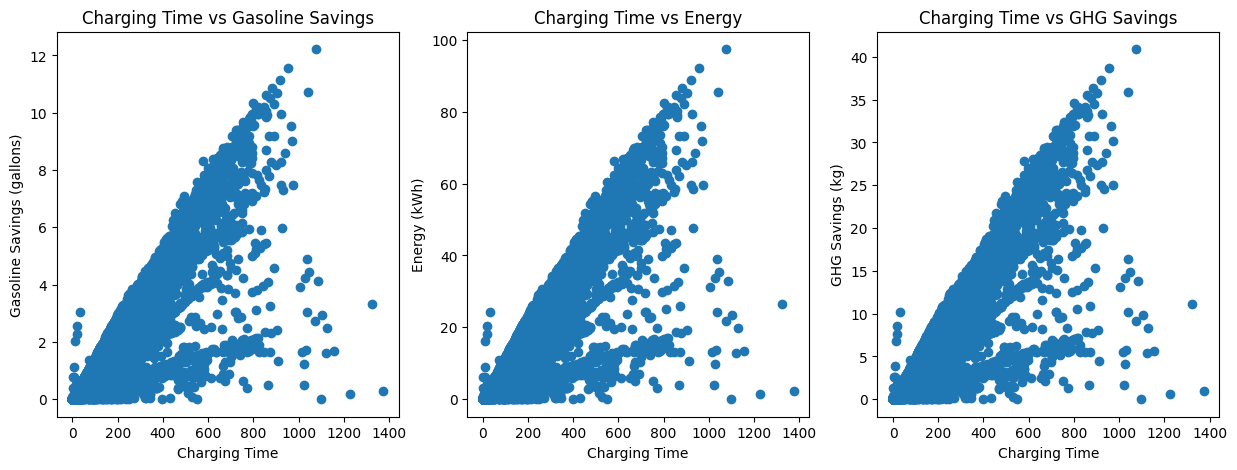

In [51]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create box plots for each dataset
axes[0].scatter(df['Charging Time'], df['Gasoline Savings (gallons)'])
axes[0].set_xlabel('Charging Time')
axes[0].set_ylabel('Gasoline Savings (gallons)')
axes[0].set_title('Charging Time vs Gasoline Savings')

axes[1].scatter(df['Charging Time'], df['Energy (kWh)'])
axes[1].set_xlabel('Charging Time')
axes[1].set_ylabel('Energy (kWh)')
axes[1].set_title('Charging Time vs Energy')

axes[2].scatter(df['Charging Time'], df['GHG Savings (kg)'])
axes[2].set_xlabel('Charging Time')
axes[2].set_ylabel('GHG Savings (kg)')
axes[2].set_title('Charging Time vs GHG Savings')

#### Visualizing the waiting time at all the 3 Postal Codes

In [52]:
df_temp = df[['Station Name', 'Minutes Passed From The Day', 'Waiting Time', 'Postal Code']]

In [53]:
def convert_minutes_to_time(minutes):
    hours = minutes // 60
    remaining_minutes = minutes % 60

    if remaining_minutes < 15:
        remaining_minutes = 0
    elif remaining_minutes < 45:
        remaining_minutes = 30
    else:
        hours += 1
        remaining_minutes = 0

    return f"{hours:02d}:{remaining_minutes:02d}"

# Apply the transformation to the 'minutes' column and create a new 'time' column
df_temp['Time'] = df_temp['Minutes Passed From The Day'].apply(convert_minutes_to_time)

df_temp.drop(columns=['Minutes Passed From The Day'], inplace=True)

<ipython-input-53-2f447fe7d4a7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Time'] = df_temp['Minutes Passed From The Day'].apply(convert_minutes_to_time)
<ipython-input-53-2f447fe7d4a7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns=['Minutes Passed From The Day'], inplace=True)


In [54]:
# create a new dataframe for zip code 94301
df_94301 = df_temp[df_temp['Postal Code'] == 94301]
df_94301.drop(columns=['Postal Code'], inplace=True)

# create a new dataframe for zip code 94303
df_94303 = df_temp[df_temp['Postal Code'] == 94303]
df_94303.drop(columns=['Postal Code'], inplace=True)

# create a new dataframe for zip code 94306
df_94306 = df_temp[df_temp['Postal Code'] == 94306]
df_94306.drop(columns=['Postal Code'], inplace=True)

<ipython-input-54-7d45da52d063>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_94301.drop(columns=['Postal Code'], inplace=True)
<ipython-input-54-7d45da52d063>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_94303.drop(columns=['Postal Code'], inplace=True)
<ipython-input-54-7d45da52d063>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_94306.drop(columns=['Postal Code'], inplace=True)


##### Visualizing the Average Waiting Time at Postal Code 94301

<Axes: title={'center': 'Average Waiting Time in 94301'}, xlabel='Time'>

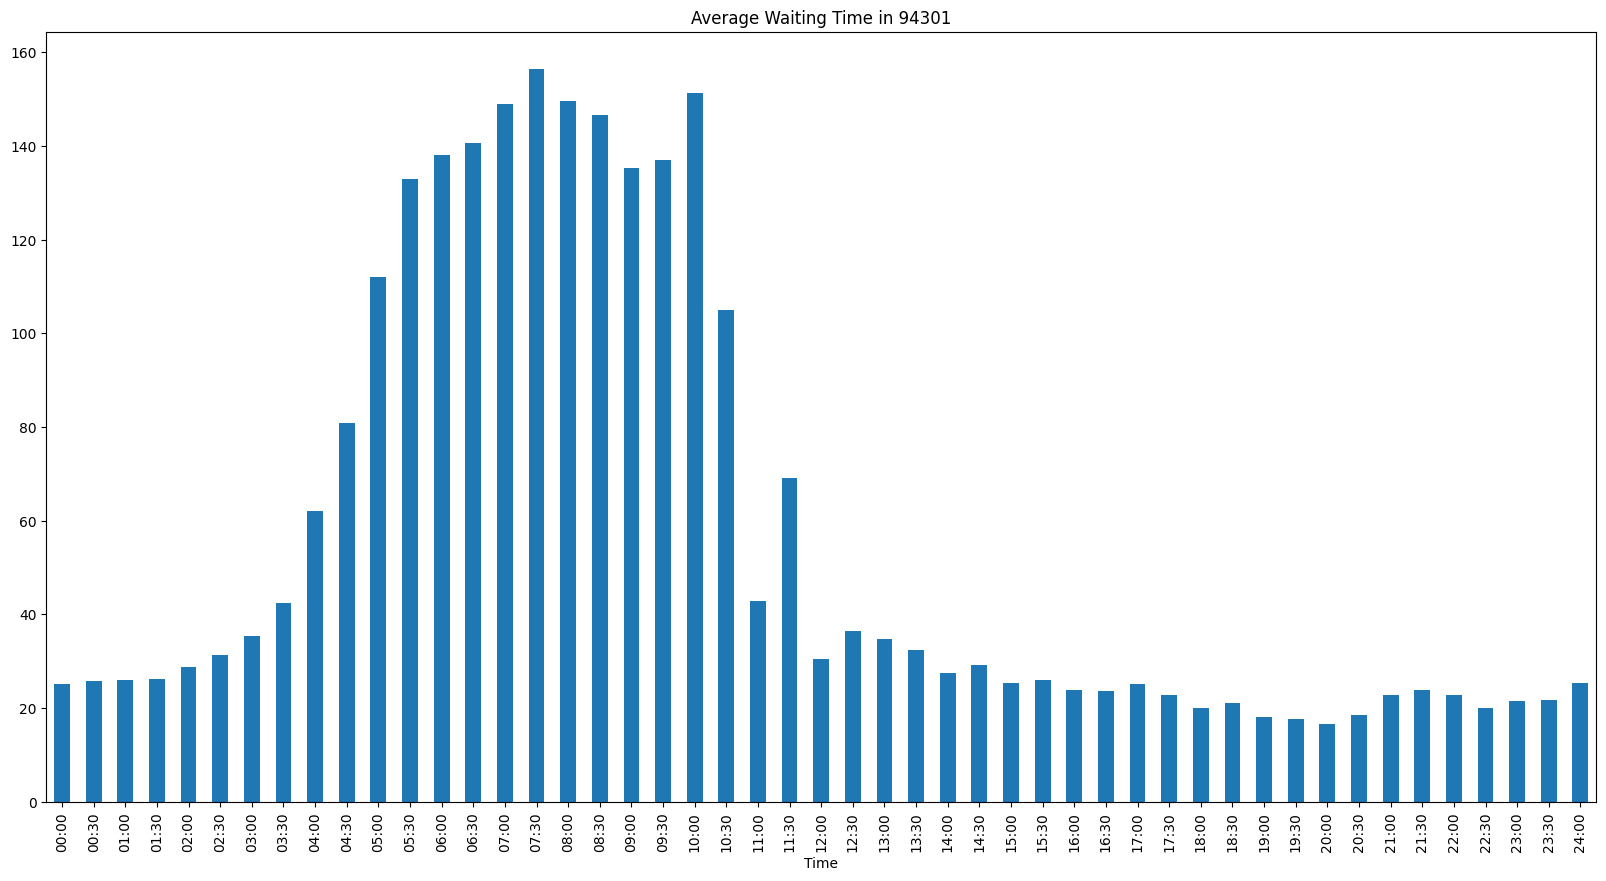

In [55]:
df_94301_mean = df_94301.groupby('Time').mean()

df_94301_mean['Waiting Time'].plot.bar(figsize=(20, 10), title='Average Waiting Time in 94301')

##### Visualizing the Average Waiting Time at Postal Code 94303

<Axes: title={'center': 'Average Waiting Time in 94303'}, xlabel='Time'>

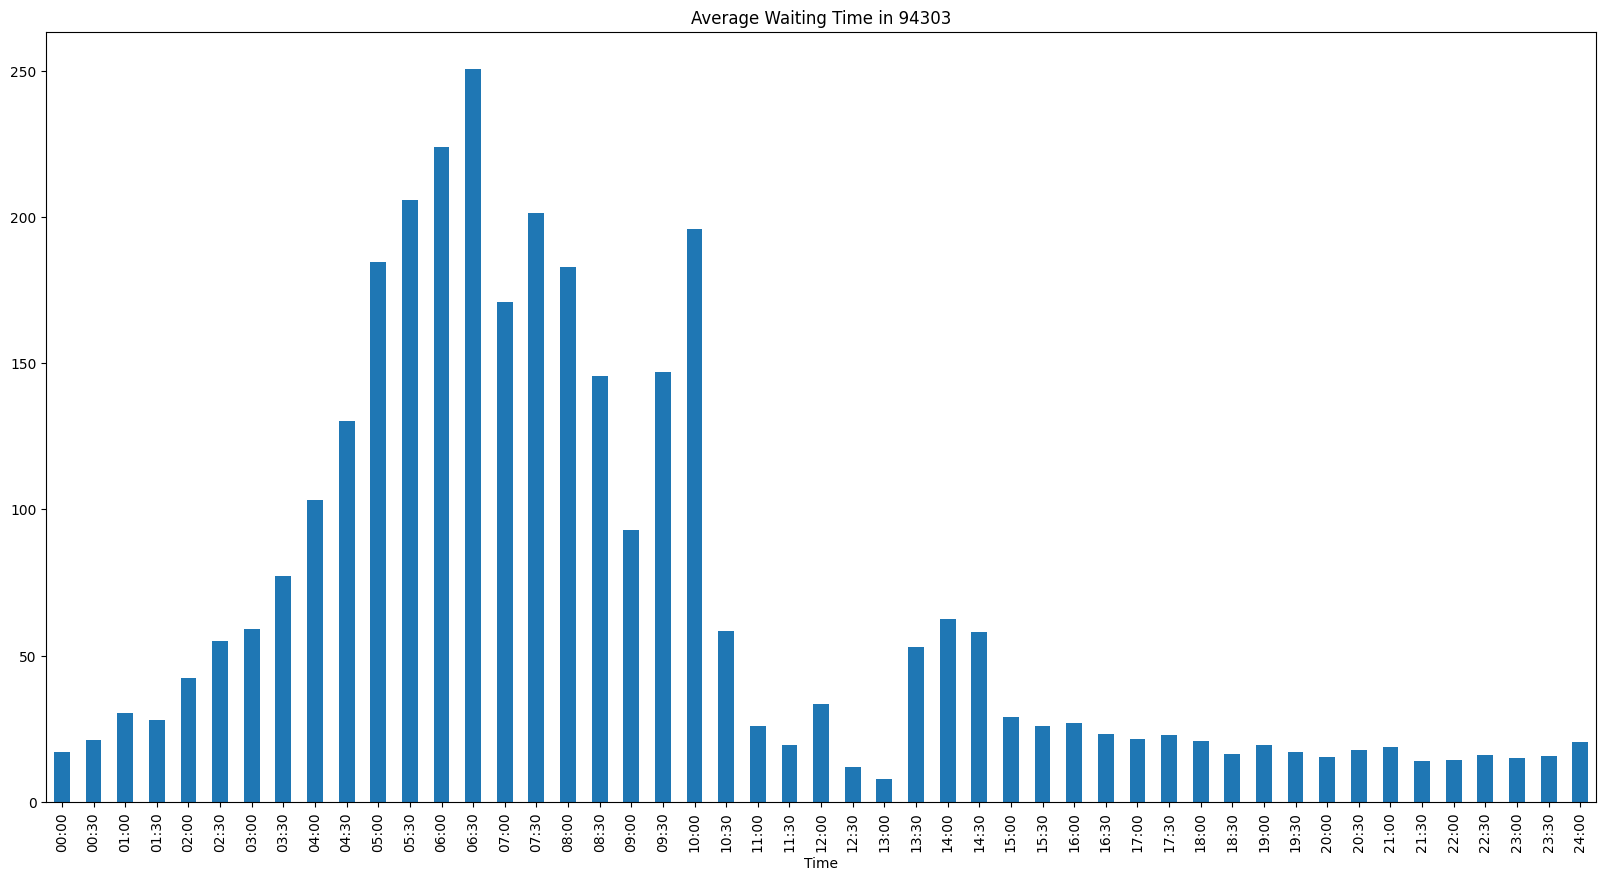

In [56]:
df_94303_mean = df_94303.groupby('Time').mean()

df_94303_mean['Waiting Time'].plot.bar(figsize=(20, 10), title='Average Waiting Time in 94303')

##### Visualizing the Average Waiting Time at Postal Code 94306

<Axes: title={'center': 'Average Waiting Time in 94306'}, xlabel='Time'>

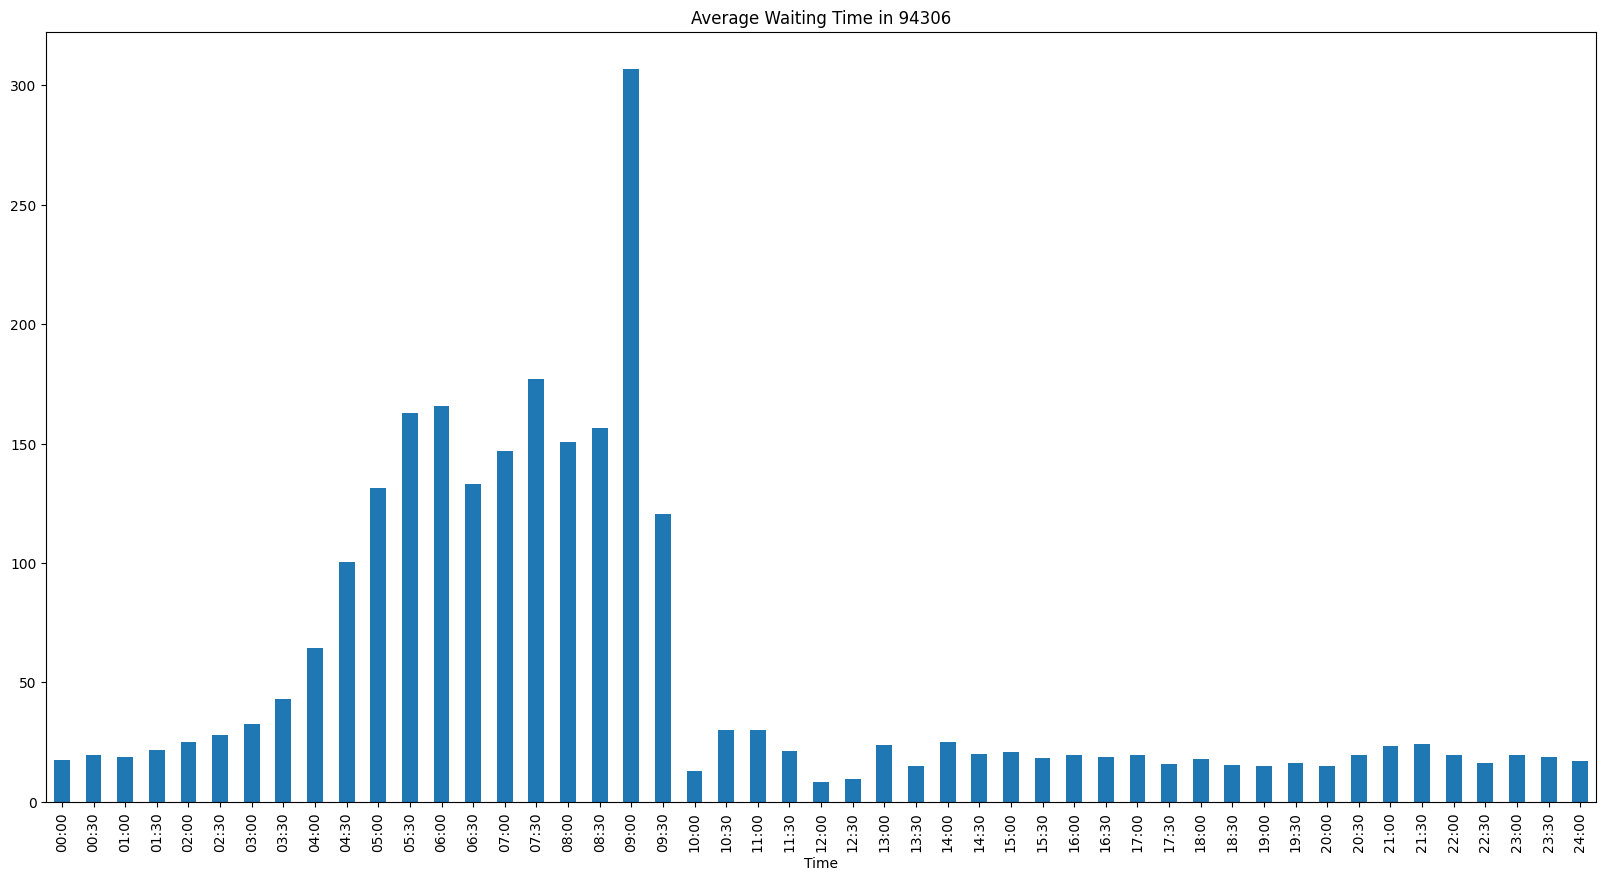

In [57]:
df_94306_mean = df_94306.groupby('Time').mean()

df_94306_mean['Waiting Time'].plot.bar(figsize=(20, 10), title='Average Waiting Time in 94306')

##### Visualizing the Average Waiting Time for entire California

<Axes: xlabel='Time'>

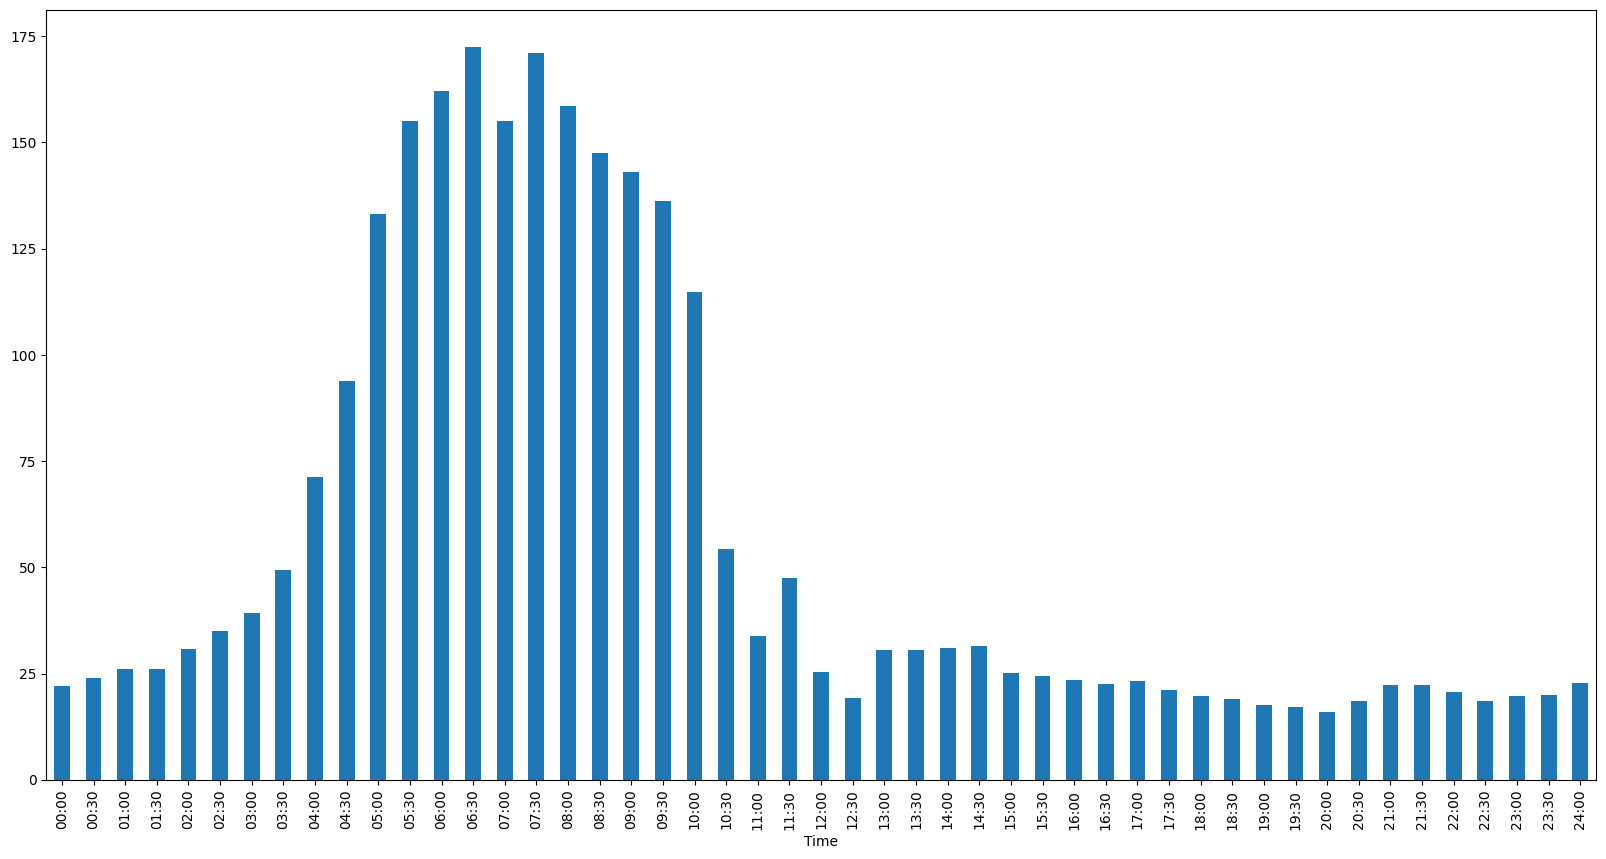

In [58]:
df_temp_mean = df_temp.groupby('Time').mean()

df_temp_mean['Waiting Time'].plot.bar(figsize=(20,10))

## Correlation Matrix of relevant features

In [59]:
df_relevant = df[['Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Charging Time', 'Fee', 'Waiting Time']]

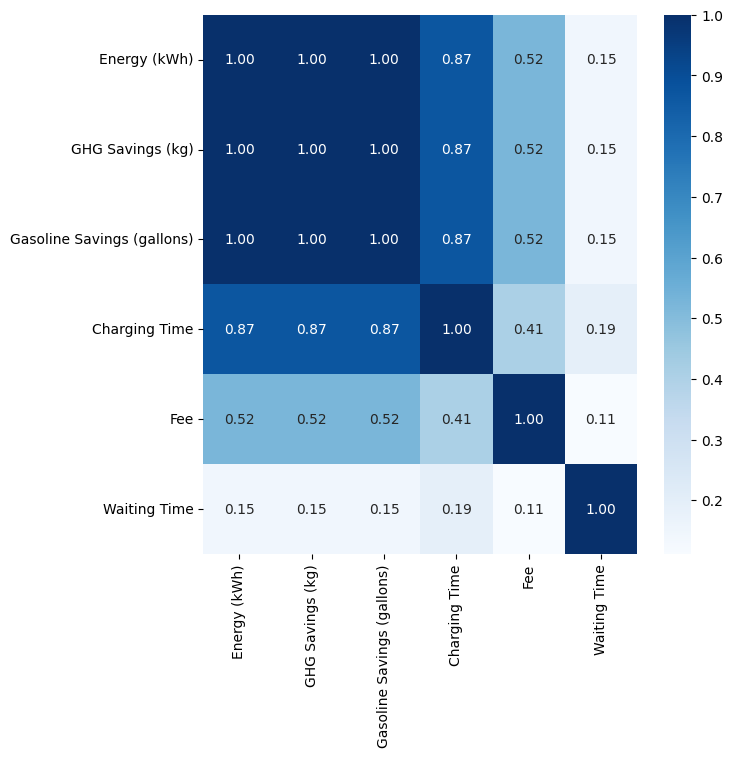

In [60]:
#  plot the correlation matrix
corr = df_relevant.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.show()

## Boxplots

Text(0.5, 0, 'Waiting Time')

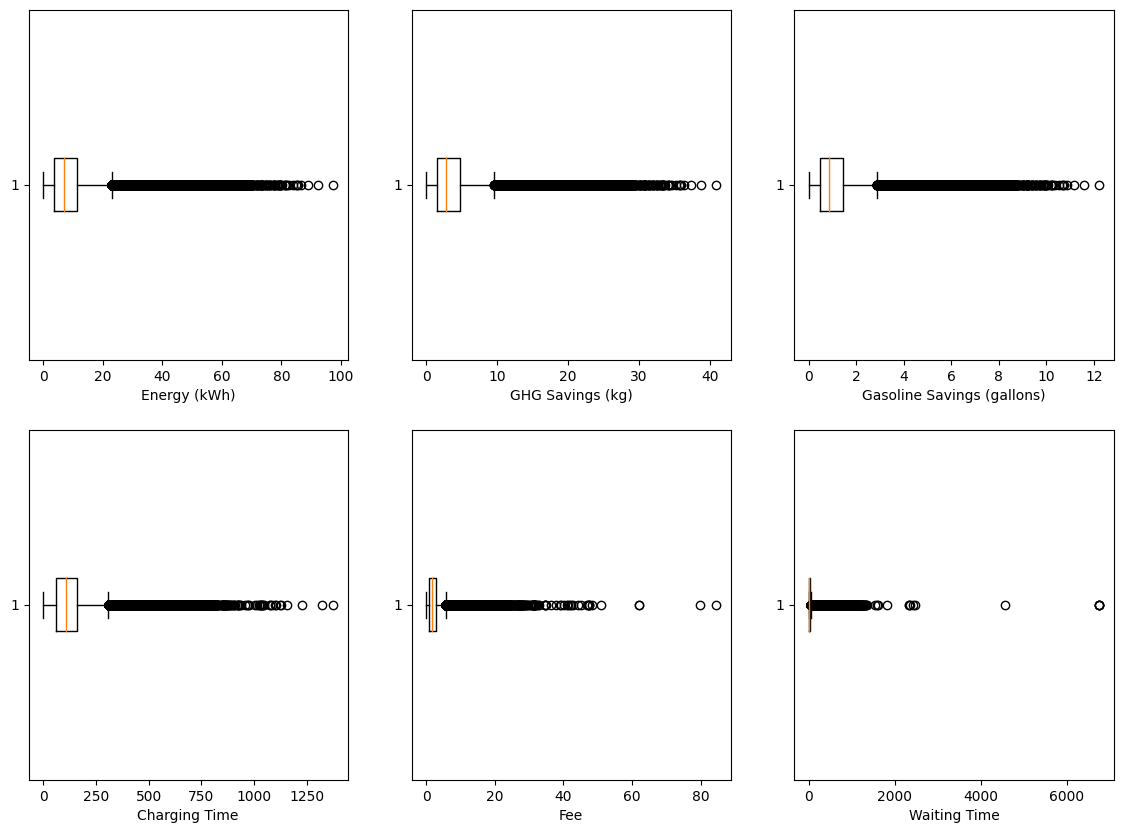

In [61]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Create box plots for each dataset
axes[0, 0].boxplot(df['Energy (kWh)'], vert=False)
axes[0, 0].set_xlabel('Energy (kWh)')

axes[0, 1].boxplot(df['GHG Savings (kg)'], vert=False)
axes[0, 1].set_xlabel('GHG Savings (kg)')

axes[0, 2].boxplot(df['Gasoline Savings (gallons)'], vert=False)
axes[0, 2].set_xlabel('Gasoline Savings (gallons)')

axes[1, 0].boxplot(df['Charging Time'], vert=False)
axes[1, 0].set_xlabel('Charging Time')

df_Fee = df[df['Fee'] != 0]
axes[1, 1].boxplot(df_Fee['Fee'], vert=False)
axes[1, 1].set_xlabel('Fee')

df_WT = df[df['Waiting Time'] >= 0]
axes[1, 2].boxplot(df_WT['Waiting Time'], vert=False)
axes[1, 2].set_xlabel('Waiting Time')

## Violinplots

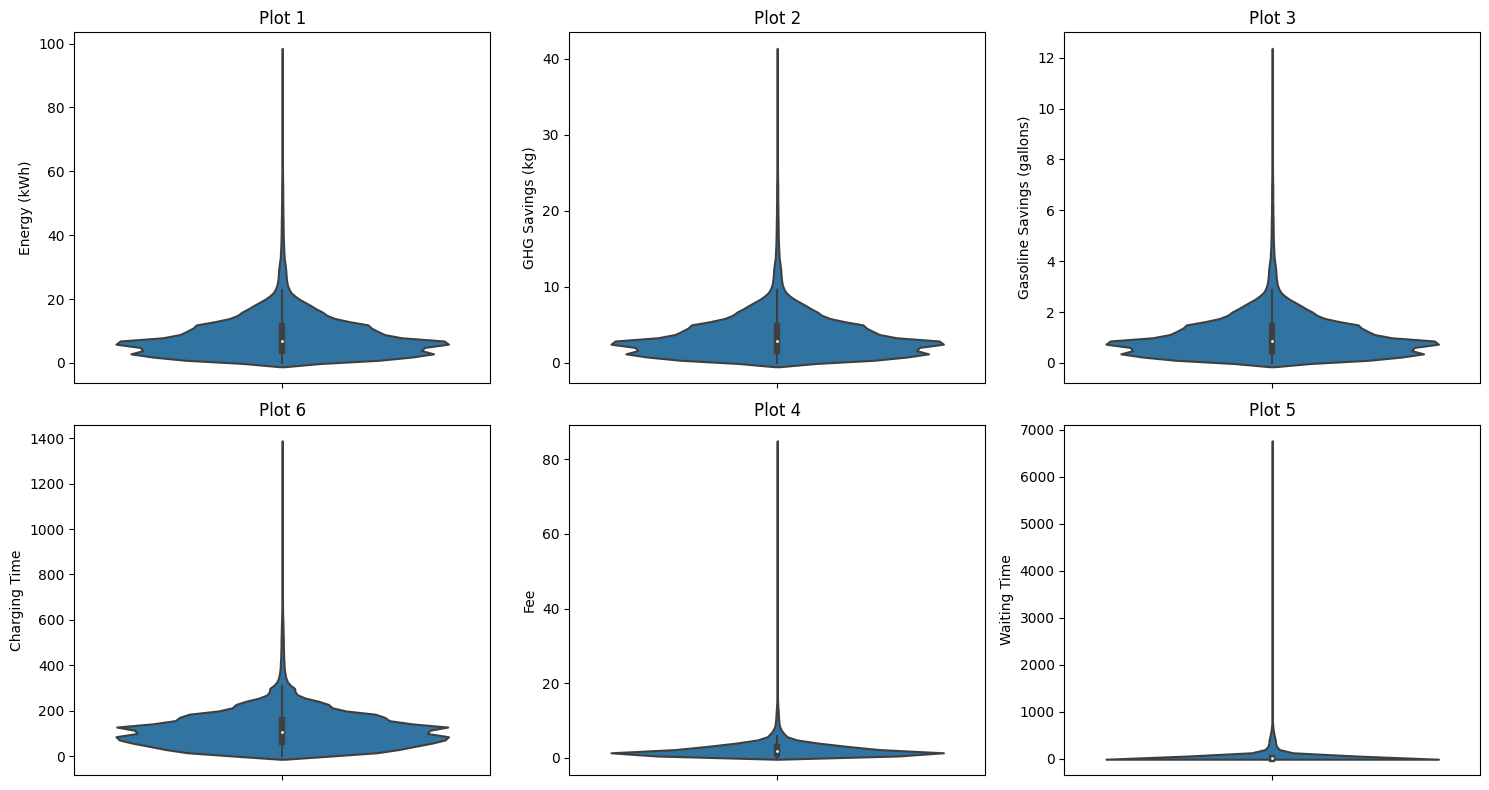

In [62]:
# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

sns.violinplot(y=df['Energy (kWh)'], ax=axes[0, 0])
axes[0, 0].set_title('Plot 1')

sns.violinplot(y=df['GHG Savings (kg)'], ax=axes[0, 1])
axes[0, 1].set_title('Plot 2')

sns.violinplot(y=df['Gasoline Savings (gallons)'], ax=axes[0, 2])
axes[0, 2].set_title('Plot 3')

sns.violinplot(y=df_WT['Charging Time'], ax=axes[1, 0])
axes[1, 0].set_title('Plot 6')

sns.violinplot(y=df_Fee['Fee'], ax=axes[1, 1])
axes[1, 1].set_title('Plot 4')

sns.violinplot(y=df_WT['Waiting Time'], ax=axes[1, 2])
axes[1, 2].set_title('Plot 5')

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

# Plotting different Year-Wise trends

# 1. Energy Consumption for each year
The figure below shows the quantity of energy consumed every year, with the exception of 2018 and 2020. People tended to stay at home during the covid pandemic (2020) . The number of forest fires that occurred in California in 2018 may have made gasoline more affordable, which might have led to a decrease in the use of EVs in that year.

We observe similar trends for GHG savings,Gasoline Savings and number of unique EV users per year.

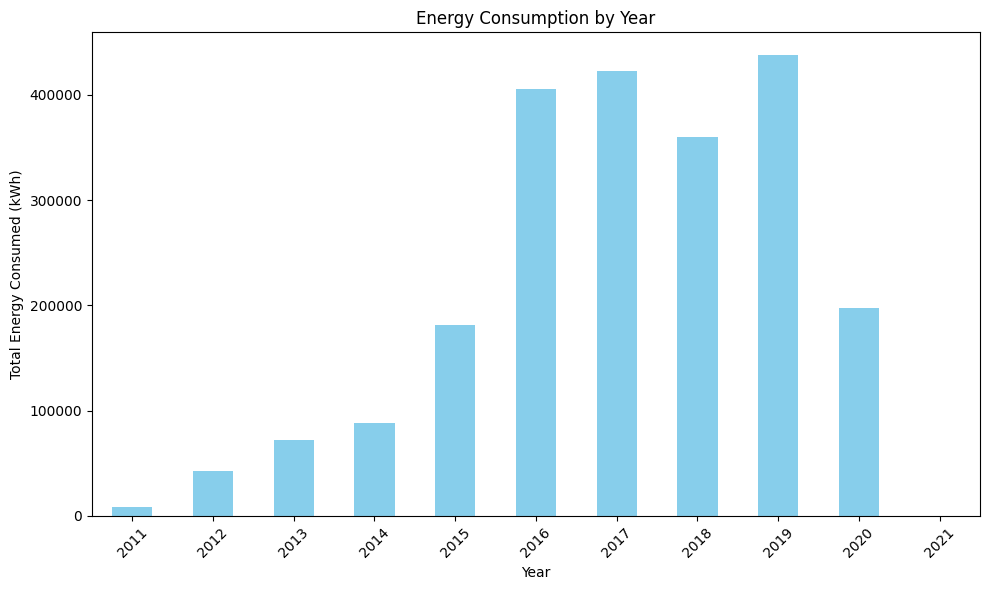

In [63]:
df['Start Date'] = pd.to_datetime(df['Start Date'], format='%m/%d/%Y %H:%M', errors='coerce')
df['Start Date'] = df['Start Date'].combine_first(pd.to_datetime(df['Start Date'], format='%m-%d-%Y %H:%M:%S', errors='coerce'))


df['Year'] = df['Start Date'].dt.year


energy_savings_by_year = df.groupby('Year')['Energy (kWh)'].sum()


plt.figure(figsize=(10, 6))
energy_savings_by_year.plot(kind='bar', color='skyblue')
plt.title('Energy Consumption by Year')
plt.xlabel('Year')
plt.ylabel('Total Energy Consumed (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


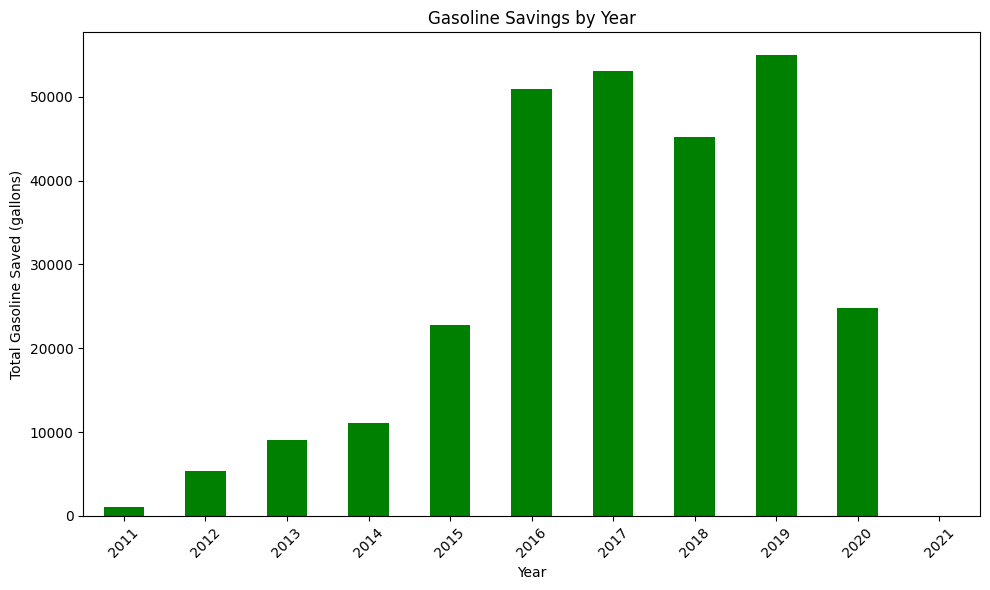

In [64]:
gasoline_savings_by_year = df.groupby('Year')['Gasoline Savings (gallons)'].sum()


plt.figure(figsize=(10, 6))
gasoline_savings_by_year.plot(kind='bar', color='green')
plt.title('Gasoline Savings by Year')
plt.xlabel('Year')
plt.ylabel('Total Gasoline Saved (gallons)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

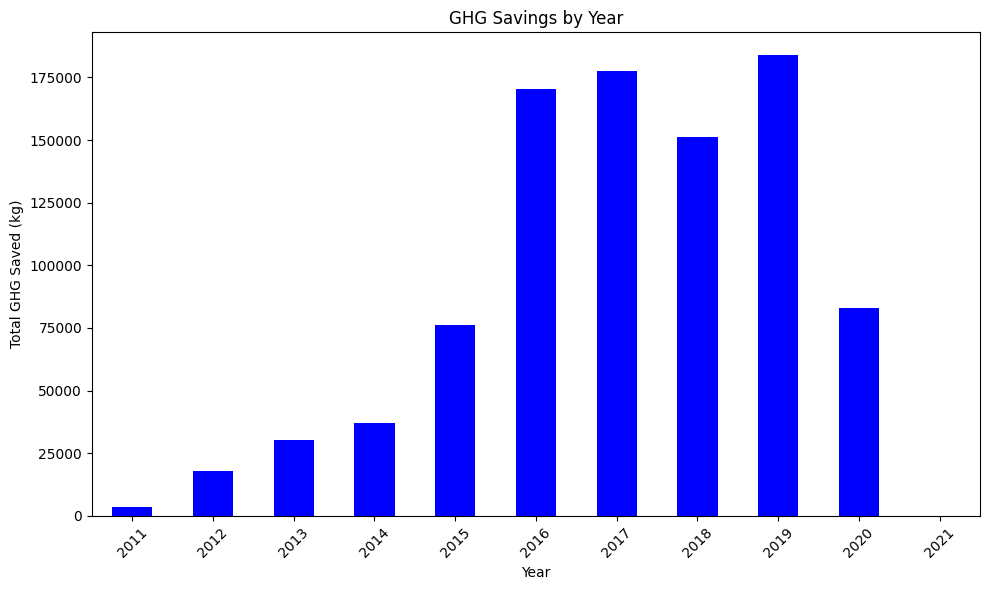

In [65]:
ghg_savings_by_year = df.groupby('Year')['GHG Savings (kg)'].sum()


plt.figure(figsize=(10, 6))
ghg_savings_by_year.plot(kind='bar', color='blue')
plt.title('GHG Savings by Year')
plt.xlabel('Year')
plt.ylabel('Total GHG Saved (kg)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

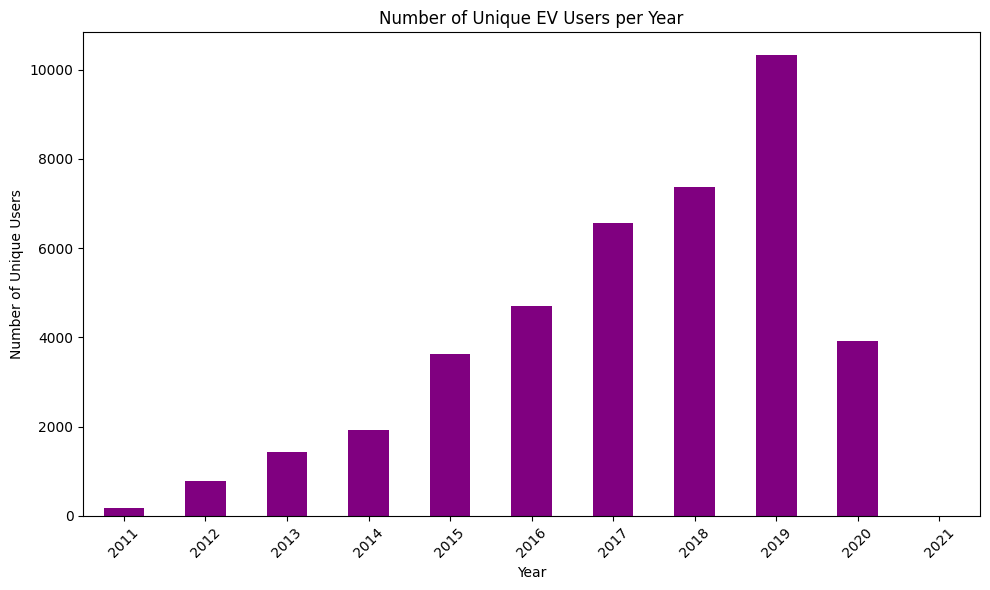

In [66]:
unique_users_per_year = df.groupby('Year')['User ID'].nunique()

# Create a bar plot for unique EV users per year
plt.figure(figsize=(10, 6))
unique_users_per_year.plot(kind='bar', color='purple')
plt.title('Number of Unique EV Users per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Correlation
The correlation between GHG Savings,Energy Consumed and Gasoline Savings is very high which is quiet intutive.A highly accurate model can be created from it as the correlation value is very high and can be predicted using a straight line.

Whereas the correaltion between year and yearly GHG Savings,Energy Consumed Yearly and Yearly Gasoline savings is relatievly low which can be justified by non-linear behaviour (as observed from the graph) as well as the exceptions for the year 2018 and 2020.


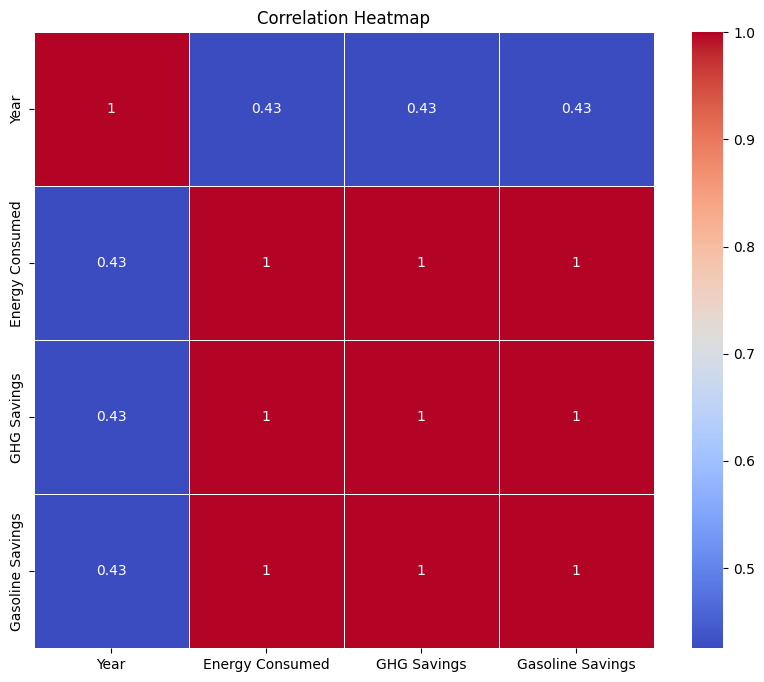

In [67]:
yearly_energy_consumption = df.groupby('Year')['Energy (kWh)'].sum()
yearly_ghg_savings = df.groupby('Year')['GHG Savings (kg)'].sum()
yearly_gasoline_savings = df.groupby('Year')['Gasoline Savings (gallons)'].sum()

# Create a new DataFrame with the calculated yearly sums
yearly_data = pd.DataFrame({
    'Year': yearly_energy_consumption.index,
    'Energy Consumed': yearly_energy_consumption.values,
    'GHG Savings': yearly_ghg_savings.values,
    'Gasoline Savings': yearly_gasoline_savings.values
})

# Calculate the correlation matrix
correlation_matrix = yearly_data.corr()

# Create a heatmap to visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-68-0454681a4175>:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('EVChargingStationUsage.csv')


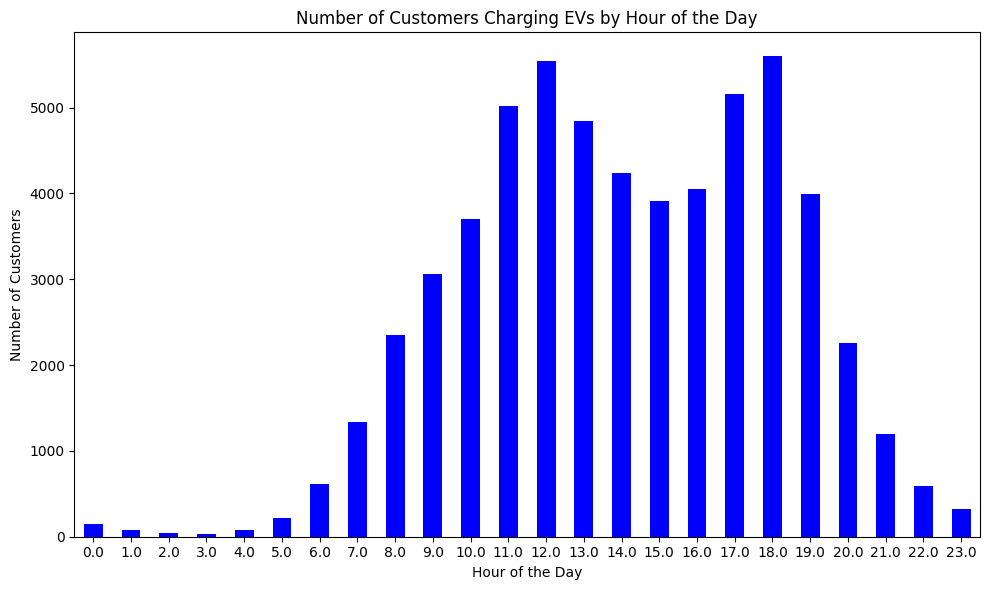

In [68]:
df1 = pd.read_csv('EVChargingStationUsage.csv')
df1['Start Date'] = pd.to_datetime(df1['Start Date'], format='%m/%d/%Y %H:%M', errors='coerce')
df1['Start Date'] = df1['Start Date'].combine_first(pd.to_datetime(df1['Start Date'], format='%m-%d-%Y %H:%M:%S', errors='coerce'))
df1['Hour'] = df1['Start Date'].dt.hour

# Group the data by hour and count the number of unique customers (User IDs)
customers_by_hour = df1.groupby('Hour')['User ID'].nunique()

# Create a bar plot to visualize the number of customers by hour
plt.figure(figsize=(10, 6))
customers_by_hour.plot(kind='bar', color='blue')
plt.title('Number of Customers Charging EVs by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

**Note that the above graph has the local time zone as it would give us better visualization as compared to time being converted to UTC as there is a difference of 7 hourse between UTC and PDT.**

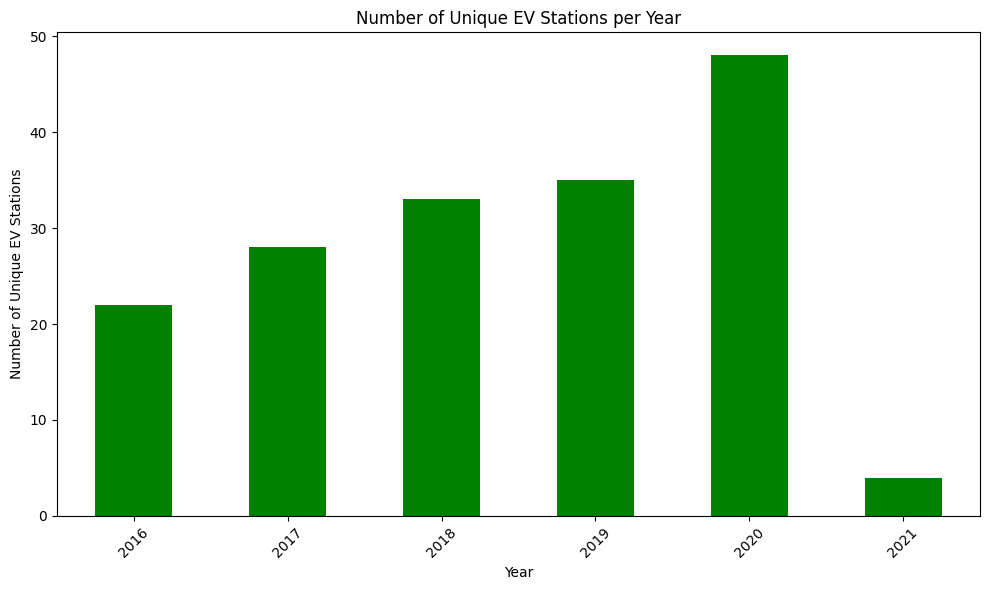

In [69]:
unique_stations_per_year = df.groupby('Year')['EVSE ID'].nunique()

# Filter out years with zero unique EV stations
unique_stations_per_year = unique_stations_per_year[unique_stations_per_year != 0]

# Create a bar plot for the number of unique EV stations per year
plt.figure(figsize=(10, 6))
unique_stations_per_year.plot(kind='bar', color='green')
plt.title('Number of Unique EV Stations per Year')
plt.xlabel('Year')
plt.ylabel('Number of Unique EV Stations')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**The above plot shows number of unique EV stations visited by customers each year.The increase in the number suggets opening of new EV stations which would ultimately help in decreasing the waiting time.**